In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path

base_dir = Path('/content/drive/MyDrive/hhd_dataset/hhd_dataset')
filepath_train = base_dir / 'TRAIN'
filepath_test = base_dir / 'TEST'

In [ ]:
filepath_test='/content/drive/MyDrive/hhd_dataset/hhd_dataset/TEST'
filepath_train='/content/drive/MyDrive/hhd_dataset/hhd_dataset/TRAIN'


## **IMPORT LIBRARIES**

In [ ]:
from google.colab import drive
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, regularizers, optimizers
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import pandas as pd
import seaborn as sb
%matplotlib inline

## **DATA ANALYSIS AND VISUALISATION**

### **Counting Images in the Dataset**

In [ ]:
# Function to count the number of images in each sub-folder and the total number of images
def count_images_in_subfolders(root_folder):
    total_image_count = 0
    unique_folders = {}

    for foldername, _, _ in os.walk(root_folder):
        if foldername != root_folder:
          image_files =glob.glob(os.path.join(foldername, '*.png'))
          image_count = len(image_files)
          total_image_count += image_count
          folder_name = os.path.basename(foldername)
          if folder_name not in unique_folders:
              unique_folders[folder_name] = 1
          else:
              unique_folders[folder_name] += 1

          print(f"len of train dataset{foldername}: {image_count}")

    num_unique_folders = len(unique_folders)
    print(f"Total number of images: {total_image_count}")
    print(f"Number of unique folders: {num_unique_folders}")
    print(unique_folders)

root_folder_path = filepath_train
count_images_in_subfolders(root_folder_path)


len of train dataset/content/drive/MyDrive/hhd_dataset/hhd_dataset/TRAIN/4: 148
len of train dataset/content/drive/MyDrive/hhd_dataset/hhd_dataset/TRAIN/8: 149
len of train dataset/content/drive/MyDrive/hhd_dataset/hhd_dataset/TRAIN/9: 149
len of train dataset/content/drive/MyDrive/hhd_dataset/hhd_dataset/TRAIN/7: 149
len of train dataset/content/drive/MyDrive/hhd_dataset/hhd_dataset/TRAIN/25: 145
len of train dataset/content/drive/MyDrive/hhd_dataset/hhd_dataset/TRAIN/5: 149
len of train dataset/content/drive/MyDrive/hhd_dataset/hhd_dataset/TRAIN/3: 149
len of train dataset/content/drive/MyDrive/hhd_dataset/hhd_dataset/TRAIN/6: 149
len of train dataset/content/drive/MyDrive/hhd_dataset/hhd_dataset/TRAIN/26: 143
len of train dataset/content/drive/MyDrive/hhd_dataset/hhd_dataset/TRAIN/21: 145
len of train dataset/content/drive/MyDrive/hhd_dataset/hhd_dataset/TRAIN/19: 149
len of train dataset/content/drive/MyDrive/hhd_dataset/hhd_dataset/TRAIN/16: 133
len of train dataset/content/drive/

In [ ]:
root_folder_path = filepath_test
count_images_in_subfolders(root_folder_path)

len of train dataset/content/drive/MyDrive/hhd_dataset/hhd_dataset/TEST/9: 45
len of train dataset/content/drive/MyDrive/hhd_dataset/hhd_dataset/TEST/8: 45
len of train dataset/content/drive/MyDrive/hhd_dataset/hhd_dataset/TEST/26: 44
len of train dataset/content/drive/MyDrive/hhd_dataset/hhd_dataset/TEST/25: 45
len of train dataset/content/drive/MyDrive/hhd_dataset/hhd_dataset/TEST/4: 45
len of train dataset/content/drive/MyDrive/hhd_dataset/hhd_dataset/TEST/7: 45
len of train dataset/content/drive/MyDrive/hhd_dataset/hhd_dataset/TEST/5: 45
len of train dataset/content/drive/MyDrive/hhd_dataset/hhd_dataset/TEST/23: 46
len of train dataset/content/drive/MyDrive/hhd_dataset/hhd_dataset/TEST/22: 32
len of train dataset/content/drive/MyDrive/hhd_dataset/hhd_dataset/TEST/3: 45
len of train dataset/content/drive/MyDrive/hhd_dataset/hhd_dataset/TEST/6: 45
len of train dataset/content/drive/MyDrive/hhd_dataset/hhd_dataset/TEST/24: 45
len of train dataset/content/drive/MyDrive/hhd_dataset/hhd_

### **Visualizing Class Distribution**


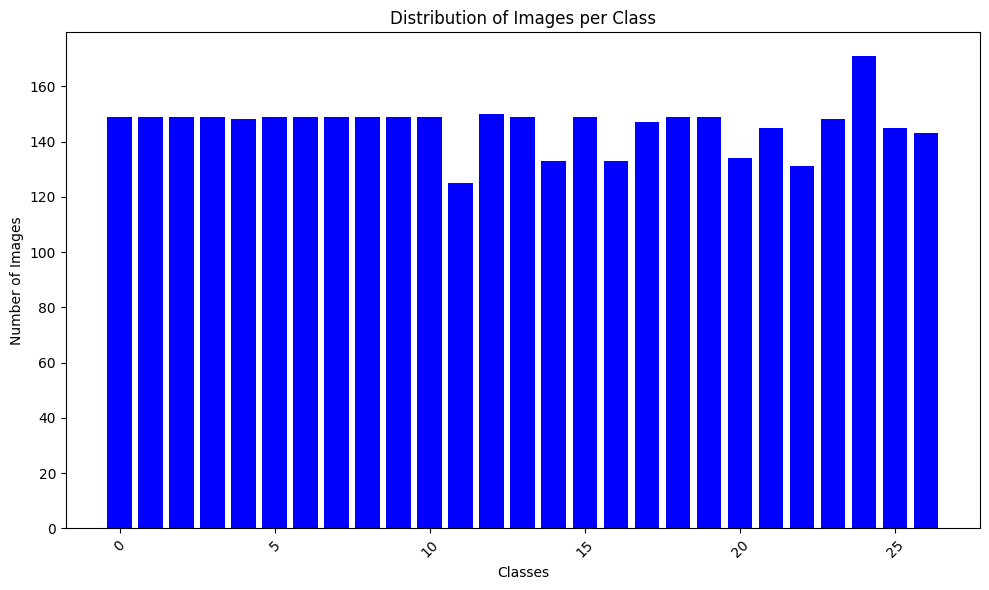

In [ ]:
import os
import matplotlib.pyplot as plt


# Dictionary to store the number of images per class
images_per_class = {}

# Traverse the subfolders
for class_name in os.listdir(filepath_train):
    class_path = os.path.join(filepath_train, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        images_per_class[int(class_name)] = num_images  # Using integers for sorting

# Sort the classes in ascending order
sorted_classes = sorted(images_per_class.keys())

# Creating the graph
plt.figure(figsize=(10, 6))
plt.bar(sorted_classes, [images_per_class[class_num] for class_num in sorted_classes], color='blue')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per Class')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the graph
plt.show()


## **DATA PREPROCESSING**

**LOAD TRAIN DATA**

In [ ]:
train_folder_path = filepath_train
batch_size = 32  # Number of samples processed before the model is updated
image_size = (128, 128)  # The dimensions to which all images will be resized
num_classes = len(os.listdir(train_folder_path))
train_images = []
train_labels = []

for foldername in os.listdir(train_folder_path):
    folder_path = os.path.join(train_folder_path, foldername)
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        image = load_img(image_path, target_size=image_size)# Load and resize the image, then append it to the train_images list
        train_images.append(image)
        train_labels.append(int(foldername))




**TRAITEMENT OF DATA**

In [ ]:
# Convert the list of PIL images to a NumPy array and normalize pixel values to the range [0, 1]
x_data = np.array([img_to_array(img) for img in train_images]) / 255.0
# Convert the list of labels to a NumPy array
y_data_labels = np.array(train_labels)
# One-hot encoding
# This converts the integer labels to a binary matrix representation.
y_data = to_categorical(y_data_labels, num_classes)



**DATA SPLITTING**

In [ ]:

# split data in train and valiation set
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42,stratify=y_data)

# print shape of dataset
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)


x_train shape: (3151, 128, 128, 3)
y_train shape: (3151, 27)
x_val shape: (788, 128, 128, 3)
y_val shape: (788, 27)


**LOAD TEST DATA**

In [ ]:
# path to the test dataset
test_folder_path = filepath_test

test_images = []
test_labels = []

for foldername in os.listdir(test_folder_path):
    folder_path = os.path.join(test_folder_path, foldername)
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        image = load_img(image_path, target_size=image_size)
        test_images.append(image)
        test_labels.append(int(foldername))



**TRAITEMENT OF TEST DATA**

In [ ]:
x_test = np.array([img_to_array(img) for img in test_images]) / 255.0
y_test_labels = np.array(test_labels)
y_test = to_categorical(y_test_labels, num_classes)



In [ ]:
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_test shape: (1134, 128, 128, 3)
y_test shape: (1134, 27)


In [ ]:
x_train[50].shape

(128, 128, 3)

In [ ]:
y_train[50]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

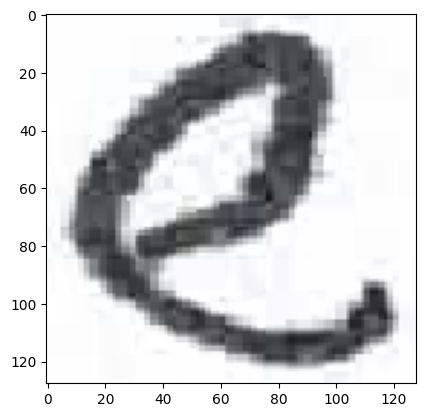

In [ ]:
plt.imshow(np.squeeze(x_train[50]), cmap='Greys_r')

In [ ]:
train_flat = x_train.reshape(-1,128,128, 3)
val_flat = x_val.reshape(-1, 128, 128, 3)
test_flat = x_test.reshape(-1,128,128, 3)
train_flat.shape
print(x_train[333])
print(train_flat[333])


[[[0.99215686 0.9882353  1.        ]
  [0.99215686 0.9882353  1.        ]
  [1.         0.99607843 1.        ]
  ...
  [0.9764706  0.972549   0.99215686]
  [0.9764706  0.972549   0.99215686]
  [0.9764706  0.972549   0.99215686]]

 [[0.99215686 0.9882353  1.        ]
  [0.99215686 0.9882353  1.        ]
  [1.         0.99607843 1.        ]
  ...
  [0.9764706  0.972549   0.99215686]
  [0.9764706  0.972549   0.99215686]
  [0.9764706  0.972549   0.99215686]]

 [[0.99215686 0.9882353  1.        ]
  [0.99215686 0.9882353  1.        ]
  [1.         0.99607843 1.        ]
  ...
  [0.9764706  0.972549   0.99215686]
  [0.9764706  0.972549   0.99215686]
  [0.9764706  0.972549   0.99215686]]

 ...

 [[0.98039216 0.98039216 0.98039216]
  [0.98039216 0.98039216 0.98039216]
  [0.9843137  0.9843137  0.9843137 ]
  ...
  [0.9882353  0.9882353  0.9882353 ]
  [0.9882353  0.9882353  0.9882353 ]
  [0.9882353  0.9882353  0.9882353 ]]

 [[0.98039216 0.98039216 0.98039216]
  [0.98039216 0.98039216 0.98039216]


## **BUILD AND TRAIN A CNN MODEL**

### **Model Architecture**

Sequential Model: The model is initialized as a sequential model which means the layers are added in sequence.

Conv2D Layers: The Conv2D layers are used to apply convolution operations. The first parameter is the number of filters and the second is the kernel size. The activation function is set as ReLU (Rectified Linear Unit).

MaxPooling2D Layers: These layers are used to reduce the spatial dimensions of the input volume.

Flatten Layer: This layer is used to flatten the 3D tensors to 1D, so that they can be fed into the fully connected layers.

Dense Layers: The dense layers (fully connected layers) are used for class predictions. The last dense layer has as many nodes as there are classes (num_classes).









In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes))

### **Training the CNN Model**

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

history = model.fit(
    x_train, y_train_labels,
    batch_size=batch_size,
    epochs=10,
    verbose=1,
    validation_data=(x_val, y_val_labels)
)


Epoch 1/10
99/99 [==============================] - 118s 1s/step - loss: 3.1814 - accuracy: 0.1238 - val_loss: 2.3529 - val_accuracy: 0.3464
Epoch 2/10
99/99 [==============================] - 111s 1s/step - loss: 1.8825 - accuracy: 0.4830 - val_loss: 1.6066 - val_accuracy: 0.5381
Epoch 3/10
99/99 [==============================] - 114s 1s/step - loss: 1.2600 - accuracy: 0.6538 - val_loss: 1.3020 - val_accuracy: 0.6256
Epoch 4/10
99/99 [==============================] - 111s 1s/step - loss: 0.9434 - accuracy: 0.7341 - val_loss: 1.2305 - val_accuracy: 0.6561
Epoch 5/10
99/99 [==============================] - 111s 1s/step - loss: 0.7093 - accuracy: 0.7997 - val_loss: 1.2323 - val_accuracy: 0.6650
Epoch 6/10
99/99 [==============================] - 109s 1s/step - loss: 0.4884 - accuracy: 0.8619 - val_loss: 1.4934 - val_accuracy: 0.6396
Epoch 7/10
99/99 [==============================] - 109s 1s/step - loss: 0.3635 - accuracy: 0.8946 - val_loss: 1.5765 - val_accuracy: 0.6497
Epoch 8/10
99

### **Plotting Training and Validation Metrics**

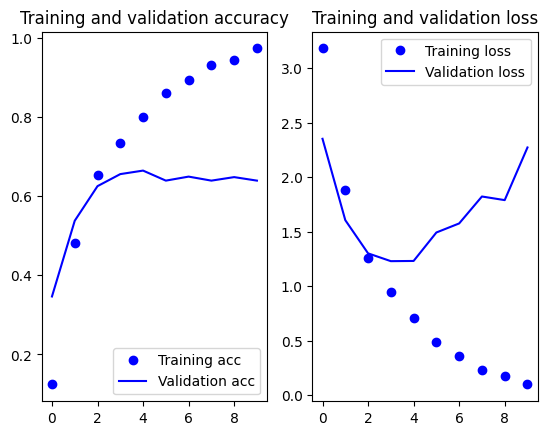

In [ ]:
def plot_training_history(history):

  plt.subplot(1, 2, 1)
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc,'bo', label='Training acc')
  plt.plot(epochs, val_acc,'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

plot_training_history(history)


In the first graph, you have two curves representing the training accuracy and validation accuracy over different epochs (training iterations). The training accuracy indicates how well the model is performing on the training data, while the validation accuracy reflects its performance on a separate validation dataset that it hasn't seen during training.

We can observe that the training accuracy consistently increases with each epoch while the validation accuracy plateaus, it's a sign of overfitting. Overfitting occurs when the model becomes very specialized in learning the training data to the point that it struggles to generalize to unseen data (validation or test data). This is why the validation accuracy doesn't improve significantly and may start to decline.

Similarly, the second graph consists of two curves representing the training loss and validation loss over epochs. The training loss indicates how well the model fits the training data; it decreases as the model learns. The validation loss, on the other hand, measures the model's performance on the validation data.

We can notice that the training loss consistently decreases while the validation loss increases over time, it also indicates overfitting. The training loss may decrease because the model is memorizing the training data, but when it encounters new data during validation, it fails to generalize well, resulting in higher validation loss.

In [ ]:
history = model.fit(
    x_train, y_train_labels,
    batch_size=batch_size,
    epochs=100,
    verbose=1,
    validation_data=(x_val, y_val_labels)
)

Epoch 1/100
99/99 [==============================] - 120s 1s/step - loss: 0.0263 - accuracy: 0.9927 - val_loss: 4.2291 - val_accuracy: 0.6180
Epoch 2/100
99/99 [==============================] - 126s 1s/step - loss: 0.0312 - accuracy: 0.9924 - val_loss: 4.7011 - val_accuracy: 0.6142
Epoch 3/100
99/99 [==============================] - 115s 1s/step - loss: 0.0544 - accuracy: 0.9835 - val_loss: 3.4732 - val_accuracy: 0.6053
Epoch 4/100
99/99 [==============================] - 119s 1s/step - loss: 0.0174 - accuracy: 0.9952 - val_loss: 4.5864 - val_accuracy: 0.6345
Epoch 5/100
99/99 [==============================] - 116s 1s/step - loss: 7.9241e-04 - accuracy: 1.0000 - val_loss: 4.9444 - val_accuracy: 0.6548
Epoch 6/100
99/99 [==============================] - 110s 1s/step - loss: 2.1256e-04 - accuracy: 1.0000 - val_loss: 5.1228 - val_accuracy: 0.6548
Epoch 7/100
99/99 [==============================] - 120s 1s/step - loss: 1.3931e-04 - accuracy: 1.0000 - val_loss: 5.2465 - val_accuracy: 0

Analysis of results:


* Overfitting:
we can see that from the fifth epoch the accuracy of the train data is 100% and the accuracy of the validate data stagnate around the 60%.
we can also see that the loss increase for the validation data which is an overfitting ignal also
* Potential solutions:
 * Regularization
 * Early stopping
 * increase data validation
 * decrease learning rate
 * decrease complexity of the model









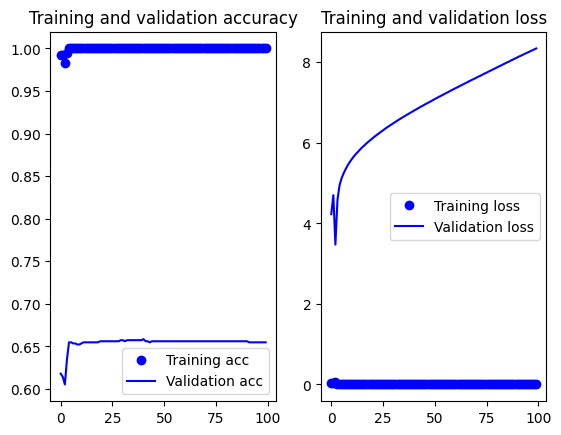

In [ ]:
plot_training_history(history)


## **CNN WITH REGULARIZATION**




L2+DROPOUT

Model

In [ ]:
# regularization rate
l2_rate = 0.01
modelL2 = models.Sequential()

# first convolutional layer with L2 regularisation
modelL2.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_rate), input_shape=(128, 128, 3)))
modelL2.add(layers.MaxPooling2D((2, 2)))

# second convolutional layer with L2 regularisation
modelL2.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_rate)))
modelL2.add(layers.MaxPooling2D((2, 2)))

# third convolutional layer with L2 regularisation
modelL2.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_rate)))
modelL2.add(layers.Flatten())

# Dense layer with L2 regularization and Dropout
modelL2.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_rate)))
modelL2.add(layers.Dropout(0.5))

# output layer
modelL2.add(layers.Dense(num_classes, activation='softmax'))


compilation model

In [ ]:
# model compilation
from keras.optimizers import Adam

# Initialisez l'optimiseur
optimizer_adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

modelL2.compile(optimizer=optimizer_adam, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

fit model

In [ ]:
history = modelL2.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=10,
    verbose=1,
    validation_data=(x_val, y_val)
)

Epoch 1/10
99/99 [==============================] - 116s 1s/step - loss: 3.7574 - accuracy: 0.0952 - val_loss: 2.7363 - val_accuracy: 0.3845
Epoch 2/10
99/99 [==============================] - 112s 1s/step - loss: 2.8226 - accuracy: 0.2882 - val_loss: 2.1660 - val_accuracy: 0.5241
Epoch 3/10
99/99 [==============================] - 112s 1s/step - loss: 2.4851 - accuracy: 0.3818 - val_loss: 1.9407 - val_accuracy: 0.5825
Epoch 4/10
99/99 [==============================] - 110s 1s/step - loss: 2.3120 - accuracy: 0.4310 - val_loss: 1.8069 - val_accuracy: 0.6142
Epoch 5/10
99/99 [==============================] - 112s 1s/step - loss: 2.1562 - accuracy: 0.4678 - val_loss: 1.7314 - val_accuracy: 0.6244
Epoch 6/10
99/99 [==============================] - 115s 1s/step - loss: 2.0581 - accuracy: 0.4891 - val_loss: 1.7189 - val_accuracy: 0.6421
Epoch 7/10
99/99 [==============================] - 112s 1s/step - loss: 1.9857 - accuracy: 0.5049 - val_loss: 1.6396 - val_accuracy: 0.6396
Epoch 8/10
99

the modelL2 shows a progression in validation accuracy while there is a decrease in loss, suggesting that there isn't any overfitting. We will increase the number of epochs to see if the accuracy continues to improve

In [ ]:
history = modelL2.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(x_val, y_val)
)

Epoch 1/20
99/99 [==============================] - 113s 1s/step - loss: 1.8151 - accuracy: 0.5595 - val_loss: 1.6350 - val_accuracy: 0.6447
Epoch 2/20
99/99 [==============================] - 111s 1s/step - loss: 1.7975 - accuracy: 0.5728 - val_loss: 1.6556 - val_accuracy: 0.6637
Epoch 3/20
99/99 [==============================] - 114s 1s/step - loss: 1.7895 - accuracy: 0.5776 - val_loss: 1.6853 - val_accuracy: 0.6675
Epoch 4/20
99/99 [==============================] - 109s 1s/step - loss: 1.7463 - accuracy: 0.5941 - val_loss: 1.6204 - val_accuracy: 0.6701
Epoch 5/20
99/99 [==============================] - 111s 1s/step - loss: 1.7361 - accuracy: 0.5827 - val_loss: 1.6230 - val_accuracy: 0.6599
Epoch 6/20
99/99 [==============================] - 113s 1s/step - loss: 1.7215 - accuracy: 0.6058 - val_loss: 1.6545 - val_accuracy: 0.6624
Epoch 7/20
99/99 [==============================] - 111s 1s/step - loss: 1.7028 - accuracy: 0.6039 - val_loss: 1.6753 - val_accuracy: 0.6675
Epoch 8/20
99

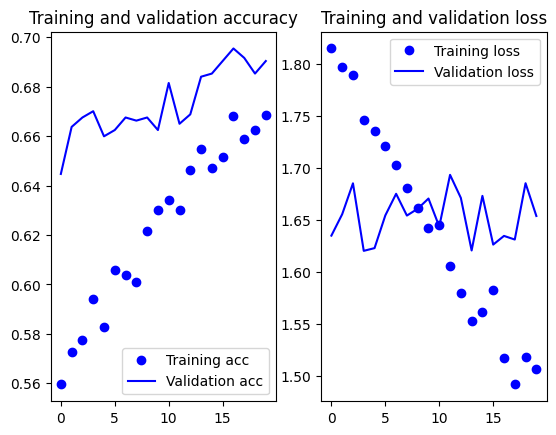

In [ ]:
plot_training_history(history)


In [ ]:
y_pred_probs = modelL2.predict(x_test)

# Conversion OF probability in classes
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Conversion of y_test in classes
y_test_classes = np.argmax(y_test, axis=1)

# Evaluation of modèle
loss, accuracy = modelL2.evaluate(x_test, y_test, verbose=0)

precision, recall, fscore, _ = score(y_test_classes, y_pred_classes, average='weighted')
measures = pd.DataFrame({'accuracy':[accuracy], 'precision': [precision], 'recall': [recall], 'fscore':[fscore]})
measures


36/36 [==============================] - 14s 399ms/step


,accuracy,precision,recall,fscore
0,0.675485,0.689119,0.675485,0.675717


<Axes: >

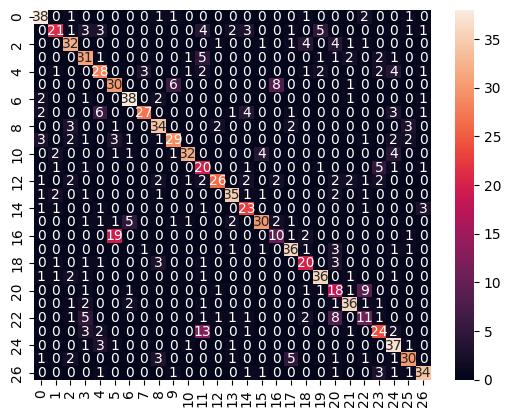

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
sb.heatmap(cm, annot=True, fmt='d')


In [ ]:
history = modelL2.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=30,
    verbose=1,
    validation_data=(x_val, y_val)
)

Epoch 1/30
99/99 [==============================] - 110s 1s/step - loss: 1.4810 - accuracy: 0.6658 - val_loss: 1.6183 - val_accuracy: 0.6954
Epoch 2/30
99/99 [==============================] - 107s 1s/step - loss: 1.4817 - accuracy: 0.6646 - val_loss: 1.6519 - val_accuracy: 0.6802
Epoch 3/30
99/99 [==============================] - 109s 1s/step - loss: 1.4579 - accuracy: 0.6798 - val_loss: 1.6009 - val_accuracy: 0.7043
Epoch 4/30
99/99 [==============================] - 106s 1s/step - loss: 1.4509 - accuracy: 0.6833 - val_loss: 1.6684 - val_accuracy: 0.6904
Epoch 5/30
99/99 [==============================] - 106s 1s/step - loss: 1.4512 - accuracy: 0.6852 - val_loss: 1.6264 - val_accuracy: 0.6751
Epoch 6/30
99/99 [==============================] - 111s 1s/step - loss: 1.4132 - accuracy: 0.6953 - val_loss: 1.7165 - val_accuracy: 0.6726
Epoch 7/30
99/99 [==============================] - 108s 1s/step - loss: 1.4133 - accuracy: 0.6937 - val_loss: 1.6784 - val_accuracy: 0.6827
Epoch 8/30
99

we can see an improvement thanks to the L2 regularization which is visible more clearly thanks to the increase in the number of epochs.
 we note the increase in accuracy which goes up to 71% whereas before it stagnated around 60%.
however I notice a difference between the losses of validation and training as the progress progresses which can indicate a beginning of overfitting

### **CNN WITH EARLY STOPPING**

In [ ]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10)
# stop after 10 epochs without improvement
modelL2.fit(x_train, y_train,epochs=30,
            ;validation_data=(x_val, y_val),
            callbacks=[early_stop])


Epoch 1/30
99/99 [==============================] - 109s 1s/step - loss: 1.8789 - accuracy: 0.4579 - val_loss: 1.5726 - val_accuracy: 0.6510
Epoch 2/30
99/99 [==============================] - 113s 1s/step - loss: 1.8612 - accuracy: 0.4732 - val_loss: 1.6369 - val_accuracy: 0.6523
Epoch 3/30
99/99 [==============================] - 111s 1s/step - loss: 1.8669 - accuracy: 0.4732 - val_loss: 1.6295 - val_accuracy: 0.6485
Epoch 4/30
99/99 [==============================] - 110s 1s/step - loss: 1.8450 - accuracy: 0.4732 - val_loss: 1.6022 - val_accuracy: 0.6637
Epoch 5/30
99/99 [==============================] - 106s 1s/step - loss: 1.8692 - accuracy: 0.4757 - val_loss: 1.5972 - val_accuracy: 0.6726
Epoch 6/30
99/99 [==============================] - 107s 1s/step - loss: 1.8260 - accuracy: 0.4814 - val_loss: 1.6266 - val_accuracy: 0.6637
Epoch 7/30
99/99 [==============================] - 112s 1s/step - loss: 1.8160 - accuracy: 0.4859 - val_loss: 1.6052 - val_accuracy: 0.6637
Epoch 8/30
99

MODEL L2+ BATCH=64

In [ ]:
history = modelL2.fit(
    x_train, y_train_labels,
    batch_size=64,
    epochs=30,
    verbose=1,
    validation_data=(x_val, y_val_labels)
)

Epoch 1/30
50/50 [==============================] - 112s 2s/step - loss: 1.4777 - accuracy: 0.6363 - val_loss: 1.5137 - val_accuracy: 0.7018
Epoch 2/30
50/50 [==============================] - 115s 2s/step - loss: 1.4042 - accuracy: 0.6658 - val_loss: 1.5278 - val_accuracy: 0.6992
Epoch 3/30
50/50 [==============================] - 110s 2s/step - loss: 1.3600 - accuracy: 0.6699 - val_loss: 1.5768 - val_accuracy: 0.7005
Epoch 4/30
50/50 [==============================] - 113s 2s/step - loss: 1.3407 - accuracy: 0.6712 - val_loss: 1.5302 - val_accuracy: 0.6853
Epoch 5/30
50/50 [==============================] - 109s 2s/step - loss: 1.3457 - accuracy: 0.6703 - val_loss: 1.5582 - val_accuracy: 0.6954
Epoch 6/30
50/50 [==============================] - 110s 2s/step - loss: 1.3310 - accuracy: 0.6731 - val_loss: 1.5701 - val_accuracy: 0.6916
Epoch 7/30
50/50 [==============================] - 108s 2s/step - loss: 1.3011 - accuracy: 0.6788 - val_loss: 1.6241 - val_accuracy: 0.6815
Epoch 8/30
50

### **CNN WITH A MORE COMPLEX MODEL**

ADD COMPLEXITY TO THE MODEL

In [ ]:
modelC = models.Sequential()

modelC.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_rate), input_shape=(128, 128, 3)))
modelC.add(layers.MaxPooling2D((2, 2)))

modelC.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_rate)))
modelC.add(layers.MaxPooling2D((2, 2)))

modelC.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_rate)))
modelC.add(layers.MaxPooling2D((2, 2)))

modelC.add(layers.Conv2D(128, (5, 5), activation='relu', kernel_regularizer=regularizers.l2(l2_rate)))
modelC.add(layers.MaxPooling2D((2, 2)))
modelC.add(layers.BatchNormalization())

modelC.add(layers.Flatten())

modelC.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_rate)))
modelC.add(layers.Dropout(0.5))

modelC.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_rate)))
modelC.add(layers.Dropout(0.5))

modelC.add(layers.Dense(num_classes, activation='softmax'))


In [ ]:
# model compilation
from keras.optimizers import Adam

# Initialisez l'optimiseur
optimizer_adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

modelC.compile(optimizer=optimizer_adam, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = modelC.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(x_val, y_val)
)

Epoch 1/20
99/99 [==============================] - 148s 1s/step - loss: 6.3787 - accuracy: 0.1438 - val_loss: 5.5495 - val_accuracy: 0.1168
Epoch 2/20
99/99 [==============================] - 147s 1s/step - loss: 4.2913 - accuracy: 0.3059 - val_loss: 4.5643 - val_accuracy: 0.2868
Epoch 3/20
99/99 [==============================] - 150s 2s/step - loss: 3.2783 - accuracy: 0.4364 - val_loss: 3.7068 - val_accuracy: 0.3211
Epoch 4/20
99/99 [==============================] - 140s 1s/step - loss: 2.7593 - accuracy: 0.4894 - val_loss: 2.6005 - val_accuracy: 0.5495
Epoch 5/20
99/99 [==============================] - 143s 1s/step - loss: 2.3861 - accuracy: 0.5398 - val_loss: 2.3946 - val_accuracy: 0.5419
Epoch 6/20
99/99 [==============================] - 139s 1s/step - loss: 2.1748 - accuracy: 0.5843 - val_loss: 1.9378 - val_accuracy: 0.6904
Epoch 7/20
99/99 [==============================] - 140s 1s/step - loss: 2.0170 - accuracy: 0.6043 - val_loss: 2.1163 - val_accuracy: 0.5749
Epoch 8/20
99

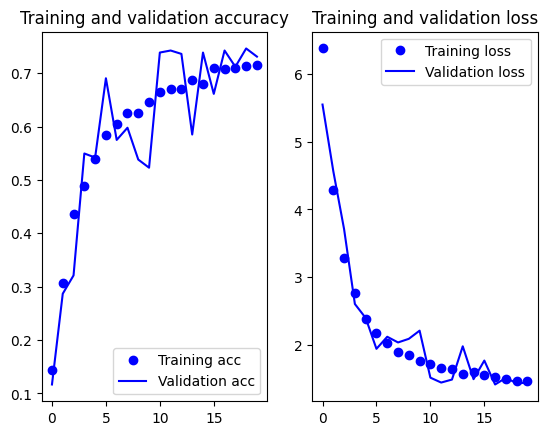

In [ ]:
plot_training_history(history)


36/36 [==============================] - 20s 548ms/step
   accuracy  precision    recall    fscore
0  0.746914   0.767644  0.746914  0.746284


<Axes: >

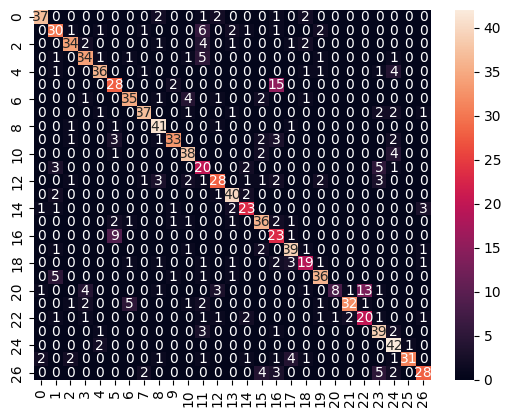

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import pandas as pd
import seaborn as sb
import numpy as np

# Prédiction du modèle
y_pred_probs = modelC.predict(x_test)

# Conversion des probabilités en classes
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Conversion de y_test en classes
y_test_classes = np.argmax(y_test, axis=1)

# Evaluation du modèle
loss, accuracy = modelC.evaluate(x_test, y_test, verbose=0)

# Calcul des métriques
precision, recall, fscore, _ = score(y_test_classes, y_pred_classes, average='weighted')
measures = pd.DataFrame({'accuracy':[accuracy], 'precision': [precision], 'recall': [recall], 'fscore':[fscore]})
print(measures)
# Matrice de confusion
cm = confusion_matrix(y_test_classes, y_pred_classes)
sb.heatmap(cm, annot=True, fmt='d')


### **DATA AUGEMENTATION**

DATA AUGEMENTATION

Import the ImageDataGenerator: The ImageDataGenerator class in Keras is used for real-time data augmentation.

Configure the ImageDataGenerator: The datagen instance is configured with several data augmentation options like feature centering, standard normalization, rotation, etc. A validation_split is also specified for splitting the data into training and validation subsets.

Fit the ImageDataGenerator: The .fit() method computes the necessary statistics for the feature-wise centering and normalization.

Create Data Generators: .flow() is used to create Python generators that will yield batches of augmented data. The subset argument specifies whether to produce batches from the training or validation subset of the data. These generators will be used later during the model training.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    fill_mode='nearest',
    validation_split = 0.2
    )

datagen.fit(x_train)
train_generator = datagen.flow(x_train, y_train_labels, batch_size=60, subset='training')
validation_generator = datagen.flow(x_train, y_train_labels, batch_size=60, subset='validation')



In [ ]:
print(len(train_generator))
print(len(validation_generator))


43
11


In [ ]:
# Use Model.fit directly
history = modelL2.fit(
    x=train_generator,
    validation_data=validation_generator,
    epochs=300,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    workers=-1,
    use_multiprocessing=True
)


Epoch 1/300


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


43/43 [==============================] - 103s 2s/step - loss: 2.5126 - accuracy: 0.3768 - val_loss: 1.5021 - val_accuracy: 0.6794
Epoch 2/300
43/43 [==============================] - 103s 2s/step - loss: 2.1718 - accuracy: 0.4161 - val_loss: 1.4553 - val_accuracy: 0.7016
Epoch 3/300
43/43 [==============================] - 102s 2s/step - loss: 2.0693 - accuracy: 0.4546 - val_loss: 1.4075 - val_accuracy: 0.6905
Epoch 4/300
43/43 [==============================] - 102s 2s/step - loss: 2.0330 - accuracy: 0.4633 - val_loss: 1.4396 - val_accuracy: 0.6968
Epoch 5/300
43/43 [==============================] - 103s 2s/step - loss: 1.9827 - accuracy: 0.4625 - val_loss: 1.4067 - val_accuracy: 0.6810
Epoch 6/300
43/43 [==============================] - 101s 2s/step - loss: 1.9424 - accuracy: 0.4748 - val_loss: 1.3760 - val_accuracy: 0.6952
Epoch 7/300
43/43 [==============================] - 100s 2s/step - loss: 1.9203 - accuracy: 0.4732 - val_loss: 1.4961 - val_accuracy: 0.6429
Epoch 8/300
43/43 

# CNN with L1 Regularization

**Regularisation L1**

In [ ]:
l1_rate=0.001

In [ ]:
# regularization rate
modelL1 = models.Sequential()

# first convolutional layer with L1 regularisation
modelL1.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l1(l1_rate), input_shape=(128, 128, 3)))
modelL1.add(layers.MaxPooling2D((2, 2)))

# second convolutional layer with L1 regularisation
modelL1.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l1(l1_rate)))
modelL1.add(layers.MaxPooling2D((2, 2)))

# third convolutional layer with L1 regularisation
modelL1.add(layers.Conv2D(128, (5, 5), activation='relu', kernel_regularizer=regularizers.l1(l1_rate)))
modelL1.add(layers.Flatten())

# Dense layer with L1 regularization and Dropout
modelL1.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1(l1_rate)))
modelL1.add(layers.Dropout(0.5))

# output layer
modelL1.add(layers.Dense(num_classes, activation='softmax'))





In [ ]:
# model compilation
from keras.optimizers import Adam

# Initialisez l'optimiseur
optimizer_adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

modelL1.compile(optimizer=optimizer_adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = modelL1.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=30,
    verbose=1,
    validation_data=(x_val, y_val)
)

Epoch 1/30
99/99 [==============================] - 175s 2s/step - loss: 8.3231 - accuracy: 0.0359 - val_loss: 4.8074 - val_accuracy: 0.0431
Epoch 2/30
99/99 [==============================] - 175s 2s/step - loss: 4.6036 - accuracy: 0.0435 - val_loss: 4.4668 - val_accuracy: 0.0431
Epoch 3/30
99/99 [==============================] - 173s 2s/step - loss: 4.3920 - accuracy: 0.0435 - val_loss: 4.2999 - val_accuracy: 0.0431
Epoch 4/30
99/99 [==============================] - 166s 2s/step - loss: 4.2773 - accuracy: 0.0435 - val_loss: 4.2391 - val_accuracy: 0.0431
Epoch 5/30
99/99 [==============================] - 176s 2s/step - loss: 4.2009 - accuracy: 0.0435 - val_loss: 4.1692 - val_accuracy: 0.0431
Epoch 6/30
99/99 [==============================] - 172s 2s/step - loss: 4.1466 - accuracy: 0.0435 - val_loss: 4.1273 - val_accuracy: 0.0431
Epoch 7/30
99/99 [==============================] - 173s 2s/step - loss: 4.1083 - accuracy: 0.0435 - val_loss: 4.0821 - val_accuracy: 0.0431
Epoch 8/30
99

## **TRANSFER LEARNING**

# VGG16

In [ ]:
#import module from tensorflow library
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

include_top, which refers to including or not the densely-connected classifier on top of the network. By default, this densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected classifier (with our 27 classes), we don't need to include it.

In [ ]:
#load the VGG16 preentrained model with the imageNet dataset.
#include_top is false because we don't include the top layers(FC) and add our classification adapted at the hdd dataset(our own dataset)
vggModel = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vggModel.summary()

In [ ]:
for layer in vggModel.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(vggModel.output)
x = Dense(64, activation='relu')(x)
output_layer = Dense(num_classes, activation='softmax')(x)

In [ ]:
model = Model(inputs=vggModel.input, outputs=output_layer)
model.compile(optimizer=Adam(lr=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:

model.fit(train_flat, y_train, batch_size=batch_size, epochs=10, validation_data=(x_val, y_val_labels))

Epoch 1/10
99/99 [==============================] - 722s 7s/step - loss: 1.9254 - accuracy: 0.4992 - val_loss: 1.1899 - val_accuracy: 0.6891
Epoch 2/10
99/99 [==============================] - 684s 7s/step - loss: 0.8230 - accuracy: 0.8020 - val_loss: 0.9010 - val_accuracy: 0.7678
Epoch 3/10
99/99 [==============================] - 687s 7s/step - loss: 0.5903 - accuracy: 0.8616 - val_loss: 0.8050 - val_accuracy: 0.7970
Epoch 4/10
99/99 [==============================] - 686s 7s/step - loss: 0.4460 - accuracy: 0.9026 - val_loss: 0.7815 - val_accuracy: 0.7982
Epoch 5/10
99/99 [==============================] - 688s 7s/step - loss: 0.3716 - accuracy: 0.9226 - val_loss: 0.7470 - val_accuracy: 0.8109
Epoch 6/10
99/99 [==============================] - 683s 7s/step - loss: 0.2996 - accuracy: 0.9330 - val_loss: 0.7494 - val_accuracy: 0.8160
Epoch 7/10
99/99 [==============================] - 692s 7s/step - loss: 0.2428 - accuracy: 0.9495 - val_loss: 0.7492 - val_accuracy: 0.8046
Epoch 8/10
99

In [ ]:
# y_train = np.argmax(y_train, axis=1)
# y_test = np.argmax(y_test, axis=1)
# model.fit(train_flat, y_train, batch_size=batch_size, epochs=10, validation_data=(x_val, y_val_labels))

Epoch 1/10
99/99 [==============================] - 787s 8s/step - loss: 1.7960 - accuracy: 0.5421 - val_loss: 1.0573 - val_accuracy: 0.7322
Epoch 2/10
99/99 [==============================] - 788s 8s/step - loss: 0.7472 - accuracy: 0.8185 - val_loss: 0.8199 - val_accuracy: 0.7754
Epoch 3/10
99/99 [==============================] - 721s 7s/step - loss: 0.5259 - accuracy: 0.8762 - val_loss: 0.7825 - val_accuracy: 0.7944
Epoch 4/10
99/99 [==============================] - 778s 8s/step - loss: 0.4153 - accuracy: 0.9026 - val_loss: 0.7475 - val_accuracy: 0.8135
Epoch 5/10
99/99 [==============================] - 774s 8s/step - loss: 0.3292 - accuracy: 0.9226 - val_loss: 0.8140 - val_accuracy: 0.7906
Epoch 6/10
99/99 [==============================] - 767s 8s/step - loss: 0.2557 - accuracy: 0.9486 - val_loss: 0.7559 - val_accuracy: 0.8020
Epoch 7/10
99/99 [==============================] - 710s 7s/step - loss: 0.2130 - accuracy: 0.9553 - val_loss: 0.7886 - val_accuracy: 0.7970
Epoch 8/10
99

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import pandas as pd
import seaborn as sb
import numpy as np

# Prédiction du modèle
y_pred_probs = model.predict(x_test)

# Conversion des probabilités en classes
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Conversion de y_test en classes

#_test_classes = np.argmax(y_test)

# Evaluation du modèle
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

# Calcul des métriques
#precision, recall, fscore, _ = score(y_test_classes, y_pred_classes, average='weighted')
precision, recall, fscore, _ = score(y_test, y_pred_classes, average='weighted')

measures = pd.DataFrame({'accuracy':[accuracy], 'precision': [precision], 'recall': [recall], 'fscore':[fscore]})
measures


36/36 [==============================] - 224s 6s/step


,accuracy,precision,recall,fscore
0,0.821869,0.828879,0.821869,0.822581


<Axes: >

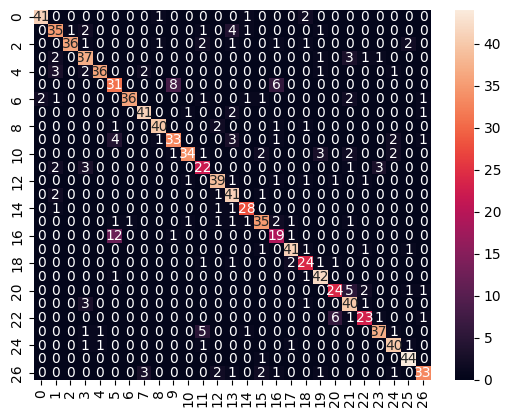

In [ ]:
# Matrice de confusion
# cm = confusion_matrix(y_test_classes, y_pred_classes)
cm = confusion_matrix(y_test, y_pred_classes)

sb.heatmap(cm, annot=True, fmt='d')

**VGG with alpha = 0.01**





In [ ]:
#load the VGG16 preentrained model with the imageNet dataset.
#include_top is false because we don't include the top layers(FC) and add our classification adapted at the hdd dataset(our own dataset)
vggModel2 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vggModel2.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [ ]:
for layer in vggModel2.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(vggModel2.output)
x = Dense(64, activation='relu')(x)
output_layer = Dense(num_classes, activation='softmax')(x)

In [ ]:
vggModel2 = Model(inputs=vggModel2.input, outputs=output_layer)
vggModel2.compile(optimizer=Adam(lr=0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

In [ ]:
historyVgg = vggModel2.fit(train_flat, y_train, batch_size=batch_size, epochs=15, validation_data=(x_val, y_val_labels))

Epoch 1/15
99/99 [==============================] - 739s 7s/step - loss: 1.8291 - accuracy: 0.5287 - val_loss: 1.0893 - val_accuracy: 0.7195
Epoch 2/15
99/99 [==============================] - 712s 7s/step - loss: 0.7731 - accuracy: 0.8064 - val_loss: 0.7920 - val_accuracy: 0.7995
Epoch 3/15
99/99 [==============================] - 699s 7s/step - loss: 0.5493 - accuracy: 0.8692 - val_loss: 0.7404 - val_accuracy: 0.8122
Epoch 4/15
99/99 [==============================] - 697s 7s/step - loss: 0.4255 - accuracy: 0.9051 - val_loss: 0.7236 - val_accuracy: 0.8046
Epoch 5/15
99/99 [==============================] - 700s 7s/step - loss: 0.3505 - accuracy: 0.9197 - val_loss: 0.7305 - val_accuracy: 0.8033
Epoch 6/15
99/99 [==============================] - 697s 7s/step - loss: 0.2875 - accuracy: 0.9353 - val_loss: 0.7256 - val_accuracy: 0.8046
Epoch 7/15
99/99 [==============================] - 697s 7s/step - loss: 0.2334 - accuracy: 0.9489 - val_loss: 0.7343 - val_accuracy: 0.8096
Epoch 8/15
99

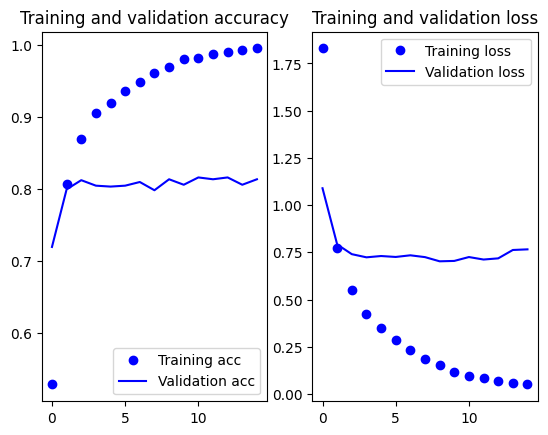

In [ ]:
plot_training_history(history)


In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import pandas as pd
import seaborn as sb
import numpy as np

# Prédiction du modèle
y_pred_probs = vggModel2.predict(x_test)

# Conversion des probabilités en classes
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Conversion de y_test en classes
#y_test_classes = np.argmax(y_test, axis=1)

# Evaluation du modèle
loss, accuracy = vggModel2.evaluate(x_test, y_test, verbose=0)

# Calcul des métriques
#precision, recall, fscore, _ = score(y_test_classes, y_pred_classes, average='weighted')
precision, recall, fscore, _ = score(y_test, y_pred_classes, average='weighted')

measures = pd.DataFrame({'accuracy':[accuracy], 'precision': [precision], 'recall': [recall], 'fscore':[fscore]})
measures



36/36 [==============================] - 205s 6s/step


,accuracy,precision,recall,fscore
0,0.822751,0.831611,0.822751,0.820259


<Axes: >

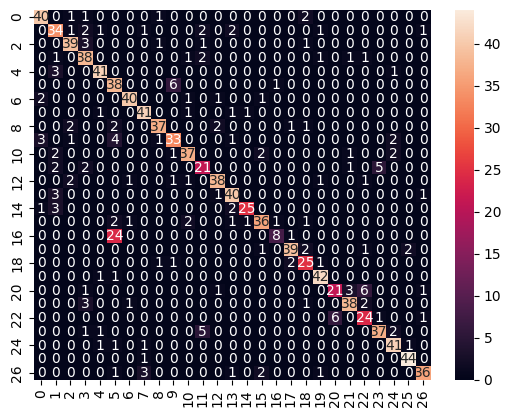

In [ ]:
# Matrice de confusion
# cm = confusion_matrix(y_test_classes, y_pred_classes)
cm = confusion_matrix(y_test, y_pred_classes)
sb.heatmap(cm, annot=True, fmt='d')

**VGG16 with adam optimizer**

In [ ]:
#load the VGG16 preentrained model with the imageNet dataset.
#include_top is false because we don't include the top layers(FC) and add our classification adapted at the hdd dataset(our own dataset)
vggModel3 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vggModel3.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
for layer in vggModel3.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(vggModel3.output)
x = Dense(64, activation='relu')(x)
output_layer = Dense(num_classes, activation='softmax')(x)

In [ ]:
vggModel3 = Model(inputs=vggModel3.input, outputs=output_layer)
# vggModel2.compile(optimizer=Adam(lr=0.01),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

In [ ]:
# model compilation
from keras.optimizers import Adam

# Initialisez l'optimiseur
optimizer_adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

vggModel3.compile(optimizer=optimizer_adam, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
historyVgg3 = vggModel3.fit(train_flat, y_train, batch_size=batch_size, epochs=15, validation_data=(x_val, y_val))

Epoch 1/15
99/99 [==============================] - 858s 9s/step - loss: 1.6825 - accuracy: 0.5665 - val_loss: 0.9542 - val_accuracy: 0.7614
Epoch 2/15
99/99 [==============================] - 859s 9s/step - loss: 0.6992 - accuracy: 0.8277 - val_loss: 0.8259 - val_accuracy: 0.7944
Epoch 3/15
99/99 [==============================] - 855s 9s/step - loss: 0.4969 - accuracy: 0.8804 - val_loss: 0.8352 - val_accuracy: 0.7830
Epoch 4/15
99/99 [==============================] - 853s 9s/step - loss: 0.3905 - accuracy: 0.9096 - val_loss: 0.7711 - val_accuracy: 0.7970
Epoch 5/15
99/99 [==============================] - 858s 9s/step - loss: 0.3054 - accuracy: 0.9210 - val_loss: 0.7483 - val_accuracy: 0.8020
Epoch 6/15
99/99 [==============================] - 855s 9s/step - loss: 0.2259 - accuracy: 0.9495 - val_loss: 0.7048 - val_accuracy: 0.8236
Epoch 7/15
99/99 [==============================] - 894s 9s/step - loss: 0.1772 - accuracy: 0.9584 - val_loss: 0.7212 - val_accuracy: 0.8261
Epoch 8/15
99

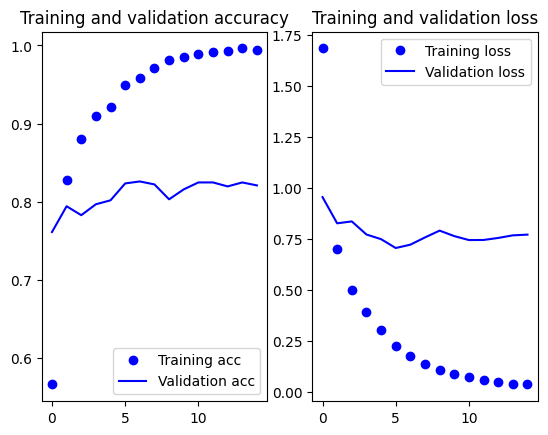

In [ ]:
plot_training_history(history)


**VGG16 with SGD optimizer**

In [ ]:
#load the VGG16 preentrained model with the imageNet dataset.
#include_top is false because we don't include the top layers(FC) and add our classification adapted at the hdd dataset(our own dataset)
vggModel4 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vggModel4.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
for layer in vggModel4.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(vggModel4.output)
x = Dense(64, activation='relu')(x)
output_layer = Dense(num_classes, activation='softmax')(x)

In [ ]:
vggModel4 = Model(inputs=vggModel4.input, outputs=output_layer)
# vggModel2.compile(optimizer=Adam(lr=0.01),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

In [ ]:
from keras.optimizers import SGD

# Initialize the SGD optimizer
optimizer_sgd = SGD(lr=0.001, momentum=0.9)

vggModel4.compile(optimizer=optimizer_sgd, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
historyVgg4 = vggModel4.fit(train_flat, y_train, batch_size=batch_size, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
99/99 [==============================] - 497s 5s/step - loss: 2.9830 - accuracy: 0.1857 - val_loss: 2.5835 - val_accuracy: 0.3147
Epoch 2/30
99/99 [==============================] - 541s 5s/step - loss: 2.1186 - accuracy: 0.5040 - val_loss: 1.8364 - val_accuracy: 0.5863
Epoch 3/30
99/99 [==============================] - 499s 5s/step - loss: 1.5376 - accuracy: 0.6557 - val_loss: 1.4022 - val_accuracy: 0.7043
Epoch 4/30
99/99 [==============================] - 497s 5s/step - loss: 1.2019 - accuracy: 0.7226 - val_loss: 1.2190 - val_accuracy: 0.7069
Epoch 5/30
99/99 [==============================] - 496s 5s/step - loss: 1.0192 - accuracy: 0.7642 - val_loss: 1.0446 - val_accuracy: 0.7411
Epoch 6/30
99/99 [==============================] - 503s 5s/step - loss: 0.9008 - accuracy: 0.7782 - val_loss: 0.9885 - val_accuracy: 0.7386
Epoch 7/30
99/99 [==============================] - 548s 6s/step - loss: 0.8291 - accuracy: 0.7918 - val_loss: 0.9017 - val_accuracy: 0.7602
Epoch 8/30
99

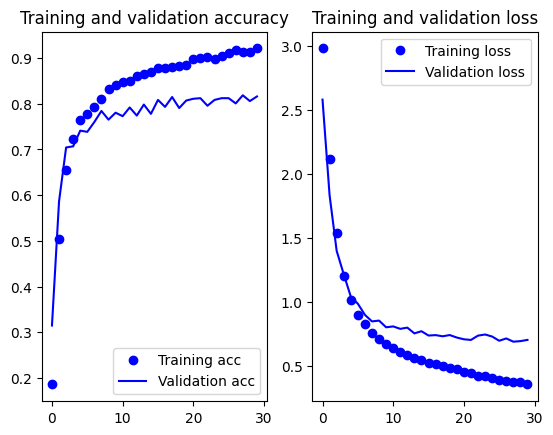

In [ ]:
plot_training_history(history)


# VGG16 with fine tuning

**VGG WITH FINE TUNING**

In [ ]:
#import module from tensorflow library
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
#load the VGG16 preentrained model with the imageNet dataset.
#include_top is false because we don't include the top layers(FC) and add our classification adapted at the hdd dataset(our own dataset)
vggModel = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vggModel.summary()

In [ ]:
for layer in vggModel.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(vggModel.output)
x = Dense(64, activation='relu')(x)
output_layer = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=vggModel.input, outputs=output_layer)


In [ ]:
model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history=model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
99/99 [==============================] - 793s 8s/step - loss: 1.7292 - accuracy: 0.5360 - val_loss: 0.9844 - val_accuracy: 0.7563
Epoch 2/10
99/99 [==============================] - 730s 7s/step - loss: 0.7273 - accuracy: 0.8185 - val_loss: 0.7877 - val_accuracy: 0.7957
Epoch 3/10
99/99 [==============================] - 787s 8s/step - loss: 0.5155 - accuracy: 0.8813 - val_loss: 0.7273 - val_accuracy: 0.8071
Epoch 4/10
99/99 [==============================] - 721s 7s/step - loss: 0.4167 - accuracy: 0.9054 - val_loss: 0.7426 - val_accuracy: 0.8020
Epoch 5/10
99/99 [==============================] - 776s 8s/step - loss: 0.3132 - accuracy: 0.9292 - val_loss: 0.7453 - val_accuracy: 0.8135
Epoch 6/10
99/99 [==============================] - 776s 8s/step - loss: 0.2493 - accuracy: 0.9438 - val_loss: 0.8297 - val_accuracy: 0.7843
Epoch 7/10
99/99 [==============================] - 777s 8s/step - loss: 0.1913 - accuracy: 0.9575 - val_loss: 0.7198 - val_accuracy: 0.8147
Epoch 8/10
99

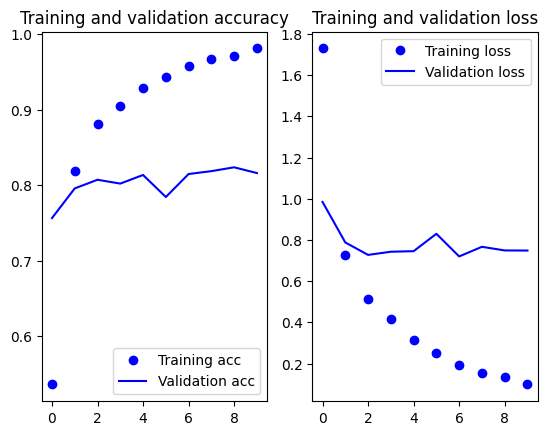

In [ ]:
plot_training_history(history)


In [ ]:
for layer in vggModel.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy', metrics=['accuracy'])

history=model.fit(x_train, y_train, epochs=10,
                  validation_data=(x_val, y_val))


Epoch 1/10
99/99 [==============================] - 2410s 24s/step - loss: 0.5875 - accuracy: 0.8353 - val_loss: 0.8150 - val_accuracy: 0.8096
Epoch 2/10
99/99 [==============================] - 2413s 24s/step - loss: 0.3011 - accuracy: 0.9057 - val_loss: 0.7425 - val_accuracy: 0.8388
Epoch 3/10
99/99 [==============================] - 2417s 24s/step - loss: 0.1994 - accuracy: 0.9464 - val_loss: 0.8022 - val_accuracy: 0.8388
Epoch 4/10
99/99 [==============================] - 2426s 25s/step - loss: 0.1544 - accuracy: 0.9505 - val_loss: 0.8279 - val_accuracy: 0.8071
Epoch 5/10
99/99 [==============================] - 2423s 24s/step - loss: 0.1712 - accuracy: 0.9464 - val_loss: 0.7923 - val_accuracy: 0.8185
Epoch 6/10
99/99 [==============================] - 2426s 25s/step - loss: 0.1154 - accuracy: 0.9587 - val_loss: 0.8903 - val_accuracy: 0.8274
Epoch 7/10
99/99 [==============================] - 2424s 24s/step - loss: 0.0895 - accuracy: 0.9708 - val_loss: 1.0373 - val_accuracy: 0.8287

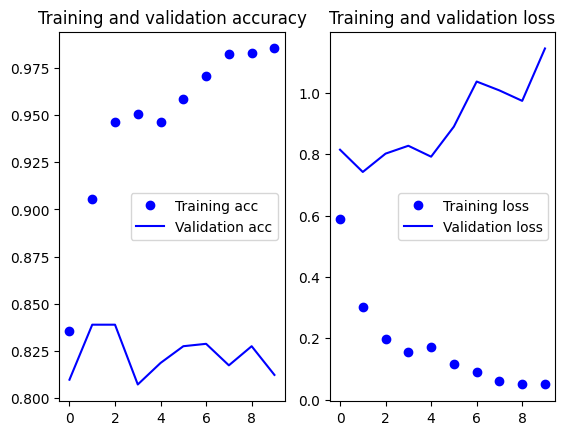

In [ ]:
plot_training_history(history)


# ResNet50

**RESNET50**

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the input shape for ResNet-50
input_shape = (128, 128, 3)

# Load the ResNet-50 model pre-trained on ImageNet data
resnetModel = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
resnetModel.summary()

# Build the top layers of the model
x = Flatten()(resnetModel.output)
x = Dense(64, activation='relu')(x)
output_layer = Dense(num_classes, activation='softmax')(x)

# Create the final model by combining the base ResNet-50 and top layers
model = Model(inputs=resnetModel.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(lr=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

In [ ]:
model.fit(train_flat, y_train, batch_size=batch_size, epochs=10, validation_data=(x_val, y_val_labels))


Epoch 1/10
99/99 [==============================] - 1056s 10s/step - loss: 3.1287 - accuracy: 0.1089 - val_loss: 3.2959 - val_accuracy: 0.0343
Epoch 2/10
99/99 [==============================] - 1002s 10s/step - loss: 2.3662 - accuracy: 0.3516 - val_loss: 3.2975 - val_accuracy: 0.0368
Epoch 3/10
99/99 [==============================] - 1007s 10s/step - loss: 1.8791 - accuracy: 0.4729 - val_loss: 3.3664 - val_accuracy: 0.0431
Epoch 4/10
99/99 [==============================] - 951s 10s/step - loss: 1.4504 - accuracy: 0.6036 - val_loss: 3.3202 - val_accuracy: 0.0368
Epoch 5/10
99/99 [==============================] - 957s 10s/step - loss: 1.0617 - accuracy: 0.7287 - val_loss: 3.2904 - val_accuracy: 0.0546
Epoch 6/10
99/99 [==============================] - 995s 10s/step - loss: 1.0056 - accuracy: 0.7642 - val_loss: 3.5028 - val_accuracy: 0.0343
Epoch 7/10
99/99 [==============================] - 1021s 10s/step - loss: 0.8572 - accuracy: 0.7680 - val_loss: 3.3120 - val_accuracy: 0.0381
Ep

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import pandas as pd
import seaborn as sb
import numpy as np

# Prédiction du modèle
y_pred_probs = model.predict(x_test)

# Conversion des probabilités en classes
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Conversion de y_test en classes
#y_test_classes = np.argmax(y_test, axis=1)

# Evaluation du modèle
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

# Calcul des métriques
#precision, recall, fscore, _ = score(y_test_classes, y_pred_classes, average='weighted')
precision, recall, fscore, _ = score(y_test, y_pred_classes, average='weighted')

measures = pd.DataFrame({'accuracy':[accuracy], 'precision': [precision], 'recall': [recall], 'fscore':[fscore]})
measures



36/36 [==============================] - 74s 2s/step


,accuracy,precision,recall,fscore
0,0.673721,0.693467,0.673721,0.667337


<Axes: >

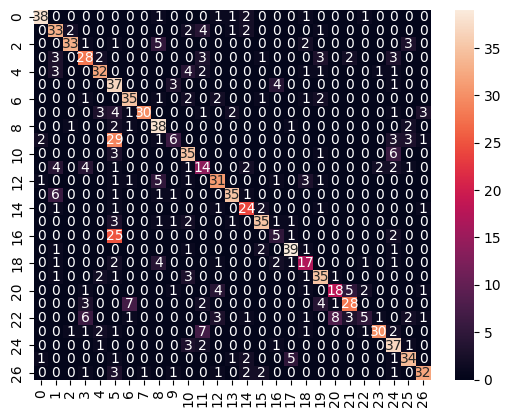

In [ ]:
# Matrice de confusion
# cm = confusion_matrix(y_test_classes, y_pred_classes)
cm = confusion_matrix(y_test, y_pred_classes)
sb.heatmap(cm, annot=True, fmt='d')

# Resnet50 with Fine Tuning

**RESNET50 WITH FINE TUNING**

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)


94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False


In [ ]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history=model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
99/99 [==============================] - 287s 3s/step - loss: 3.2811 - accuracy: 0.0689 - val_loss: 3.1087 - val_accuracy: 0.1256
Epoch 2/10
99/99 [==============================] - 279s 3s/step - loss: 3.0272 - accuracy: 0.1568 - val_loss: 2.8399 - val_accuracy: 0.2830
Epoch 3/10
99/99 [==============================] - 245s 2s/step - loss: 2.7515 - accuracy: 0.2368 - val_loss: 2.5612 - val_accuracy: 0.3198
Epoch 4/10
99/99 [==============================] - 246s 2s/step - loss: 2.4977 - accuracy: 0.2977 - val_loss: 2.2935 - val_accuracy: 0.4162
Epoch 5/10
99/99 [==============================] - 280s 3s/step - loss: 2.2847 - accuracy: 0.3532 - val_loss: 2.0900 - val_accuracy: 0.4797
Epoch 6/10
99/99 [==============================] - 280s 3s/step - loss: 2.1202 - accuracy: 0.3938 - val_loss: 1.9382 - val_accuracy: 0.5114
Epoch 7/10
99/99 [==============================] - 284s 3s/step - loss: 1.9694 - accuracy: 0.4288 - val_loss: 1.7957 - val_accuracy: 0.5533
Epoch 8/10
99

In [ ]:
history=model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))


Epoch 1/20
99/99 [==============================] - 299s 3s/step - loss: 3.2642 - accuracy: 0.0714 - val_loss: 3.0649 - val_accuracy: 0.1434
Epoch 2/20
99/99 [==============================] - 294s 3s/step - loss: 2.9761 - accuracy: 0.1726 - val_loss: 2.7642 - val_accuracy: 0.3109
Epoch 3/20
99/99 [==============================] - 255s 3s/step - loss: 2.6954 - accuracy: 0.2510 - val_loss: 2.4773 - val_accuracy: 0.4416
Epoch 4/20
99/99 [==============================] - 285s 3s/step - loss: 2.4307 - accuracy: 0.3247 - val_loss: 2.2244 - val_accuracy: 0.4581
Epoch 5/20
99/99 [==============================] - 283s 3s/step - loss: 2.2245 - accuracy: 0.3738 - val_loss: 2.0347 - val_accuracy: 0.4911
Epoch 6/20
99/99 [==============================] - 282s 3s/step - loss: 2.0638 - accuracy: 0.4100 - val_loss: 1.8958 - val_accuracy: 0.5266
Epoch 7/20
99/99 [==============================] - 284s 3s/step - loss: 1.9122 - accuracy: 0.4583 - val_loss: 1.7817 - val_accuracy: 0.5457
Epoch 8/20
99

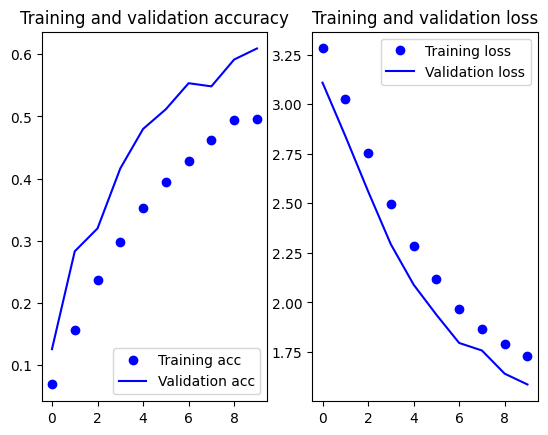

In [ ]:
plot_training_history(history)


In [ ]:
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))


Epoch 1/10
99/99 [==============================] - 417s 4s/step - loss: 1.9738 - accuracy: 0.5370 - val_loss: 2.6371 - val_accuracy: 0.3236
Epoch 2/10
99/99 [==============================] - 397s 4s/step - loss: 1.0417 - accuracy: 0.6820 - val_loss: 3.8575 - val_accuracy: 0.2398
Epoch 3/10
99/99 [==============================] - 388s 4s/step - loss: 0.8608 - accuracy: 0.7385 - val_loss: 2.1160 - val_accuracy: 0.4670
Epoch 4/10
99/99 [==============================] - 348s 4s/step - loss: 0.7700 - accuracy: 0.7750 - val_loss: 1.4025 - val_accuracy: 0.6320
Epoch 5/10
99/99 [==============================] - 386s 4s/step - loss: 0.6967 - accuracy: 0.7842 - val_loss: 1.1243 - val_accuracy: 0.7259
Epoch 6/10
99/99 [==============================] - 383s 4s/step - loss: 0.6250 - accuracy: 0.8067 - val_loss: 1.0503 - val_accuracy: 0.7437
Epoch 7/10
99/99 [==============================] - 387s 4s/step - loss: 0.5686 - accuracy: 0.8258 - val_loss: 1.2199 - val_accuracy: 0.7183
Epoch 8/10
99

In [ ]:
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))


Epoch 1/10
99/99 [==============================] - 417s 4s/step - loss: 1.9738 - accuracy: 0.5370 - val_loss: 2.6371 - val_accuracy: 0.3236
Epoch 2/10
99/99 [==============================] - 397s 4s/step - loss: 1.0417 - accuracy: 0.6820 - val_loss: 3.8575 - val_accuracy: 0.2398
Epoch 3/10
99/99 [==============================] - 388s 4s/step - loss: 0.8608 - accuracy: 0.7385 - val_loss: 2.1160 - val_accuracy: 0.4670
Epoch 4/10
99/99 [==============================] - 348s 4s/step - loss: 0.7700 - accuracy: 0.7750 - val_loss: 1.4025 - val_accuracy: 0.6320
Epoch 5/10
99/99 [==============================] - 386s 4s/step - loss: 0.6967 - accuracy: 0.7842 - val_loss: 1.1243 - val_accuracy: 0.7259
Epoch 6/10
99/99 [==============================] - 383s 4s/step - loss: 0.6250 - accuracy: 0.8067 - val_loss: 1.0503 - val_accuracy: 0.7437
Epoch 7/10
99/99 [==============================] - 387s 4s/step - loss: 0.5686 - accuracy: 0.8258 - val_loss: 1.2199 - val_accuracy: 0.7183
Epoch 8/10
99

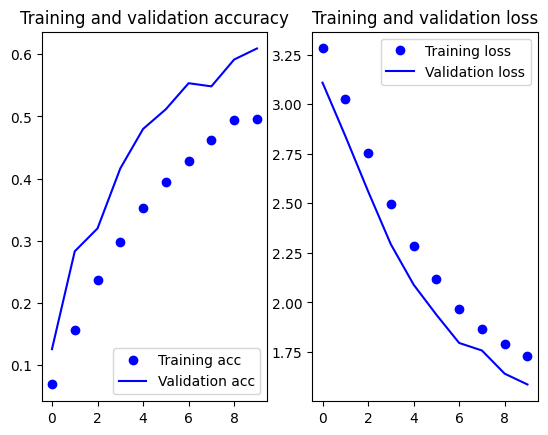

In [ ]:
plot_training_history(history)


In [ ]:
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))


Epoch 1/20
99/99 [==============================] - 421s 4s/step - loss: 0.5104 - accuracy: 0.8420 - val_loss: 1.3592 - val_accuracy: 0.6904
Epoch 2/20
99/99 [==============================] - 388s 4s/step - loss: 0.4951 - accuracy: 0.8480 - val_loss: 1.1797 - val_accuracy: 0.7297
Epoch 3/20
99/99 [==============================] - 382s 4s/step - loss: 0.3882 - accuracy: 0.8712 - val_loss: 1.3135 - val_accuracy: 0.7437
Epoch 4/20
99/99 [==============================] - 351s 4s/step - loss: 0.4002 - accuracy: 0.8712 - val_loss: 1.2110 - val_accuracy: 0.7475
Epoch 5/20
99/99 [==============================] - 349s 4s/step - loss: 0.3502 - accuracy: 0.8816 - val_loss: 1.3827 - val_accuracy: 0.7107
Epoch 6/20
99/99 [==============================] - 387s 4s/step - loss: 0.3454 - accuracy: 0.8915 - val_loss: 1.2841 - val_accuracy: 0.7360
Epoch 7/20
99/99 [==============================] - 382s 4s/step - loss: 0.2909 - accuracy: 0.9096 - val_loss: 1.3501 - val_accuracy: 0.7513
Epoch 8/20
99

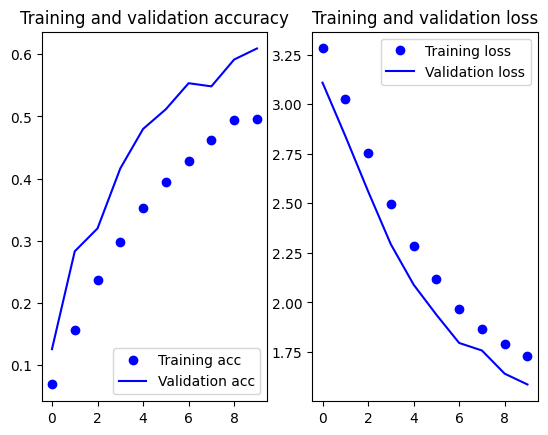

In [ ]:
plot_training_history(history)


In [ ]:
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001,
              loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val))


Epoch 1/30
99/99 [==============================] - 370s 4s/step - loss: 0.3390 - accuracy: 0.8911 - val_loss: 1.0652 - val_accuracy: 0.7741
Epoch 2/30
99/99 [==============================] - 392s 4s/step - loss: 0.2766 - accuracy: 0.9096 - val_loss: 1.0539 - val_accuracy: 0.7830
Epoch 3/30
99/99 [==============================] - 393s 4s/step - loss: 0.2599 - accuracy: 0.9169 - val_loss: 1.1096 - val_accuracy: 0.7881
Epoch 4/30
99/99 [==============================] - 393s 4s/step - loss: 0.2345 - accuracy: 0.9238 - val_loss: 1.1563 - val_accuracy: 0.7868
Epoch 5/30
99/99 [==============================] - 394s 4s/step - loss: 0.2294 - accuracy: 0.9219 - val_loss: 1.2196 - val_accuracy: 0.7741
Epoch 6/30
99/99 [==============================] - 395s 4s/step - loss: 0.2069 - accuracy: 0.9318 - val_loss: 1.2202 - val_accuracy: 0.7805
Epoch 7/30
99/99 [==============================] - 370s 4s/step - loss: 0.1990 - accuracy: 0.9337 - val_loss: 1.2484 - val_accuracy: 0.7805
Epoch 8/30
99